<img src="../logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales

# Trabajo Práctico Nº10
#### Federico Borello

# Filtrado No Lineal

Se sigue la [guía de laboratorio](https://github.com/marianux/tps_pds/blob/master/TP4%20-%20Filtrado.ipynb) propuesta por la cátedra.

# Seteo las Señales

In [1]:
# SetUp
import scipy.signal as sig
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio

mat_struct = sio.loadmat("../TS8/ECG_TP4.mat")
ecg_one_lead = mat_struct["ecg_lead"]
ecg_one_lead = ecg_one_lead.flatten()
ecg_one_lead_contaminated_big = ecg_one_lead[100000:290000]
ecg_one_lead_contaminated_small = ecg_one_lead[100000:150000]
ecg_one_lead_contaminated_smallest = ecg_one_lead[100000:105000]

fs = 1000  # Hz
nyq_frec = fs / 2

# Filtrado de mediana

La estimación del movimiento de línea de base es un paso crucial en el análisis de señales de electrocardiograma (ECG), ya que permite eliminar componentes no deseados y resaltar la actividad eléctrica cardíaca. En este contexto, se utilizará el filtrado de mediana para estimar el movimiento de línea de base. Este método consiste en calcular, muestra a muestra, la mediana de la señal ECG en un intervalo de 200 ms previos a cada muestra actual.

Se calcula muestra a muestra la mediana en los 200 ms previos a la muestra actual. Luego dicha estimación la substraemos para estimar la actividad eléctrica cardíaca:

$$
\text{Línea de base} = ECG(t) - \text{Mediana}(ECG(t - 200 \, \text{ms}), \ldots, ECG(t - 1 \, \text{ms}))
$$

Por último:

$$
\hat{x} = ECG(t) - \text{Línea de base}
$$


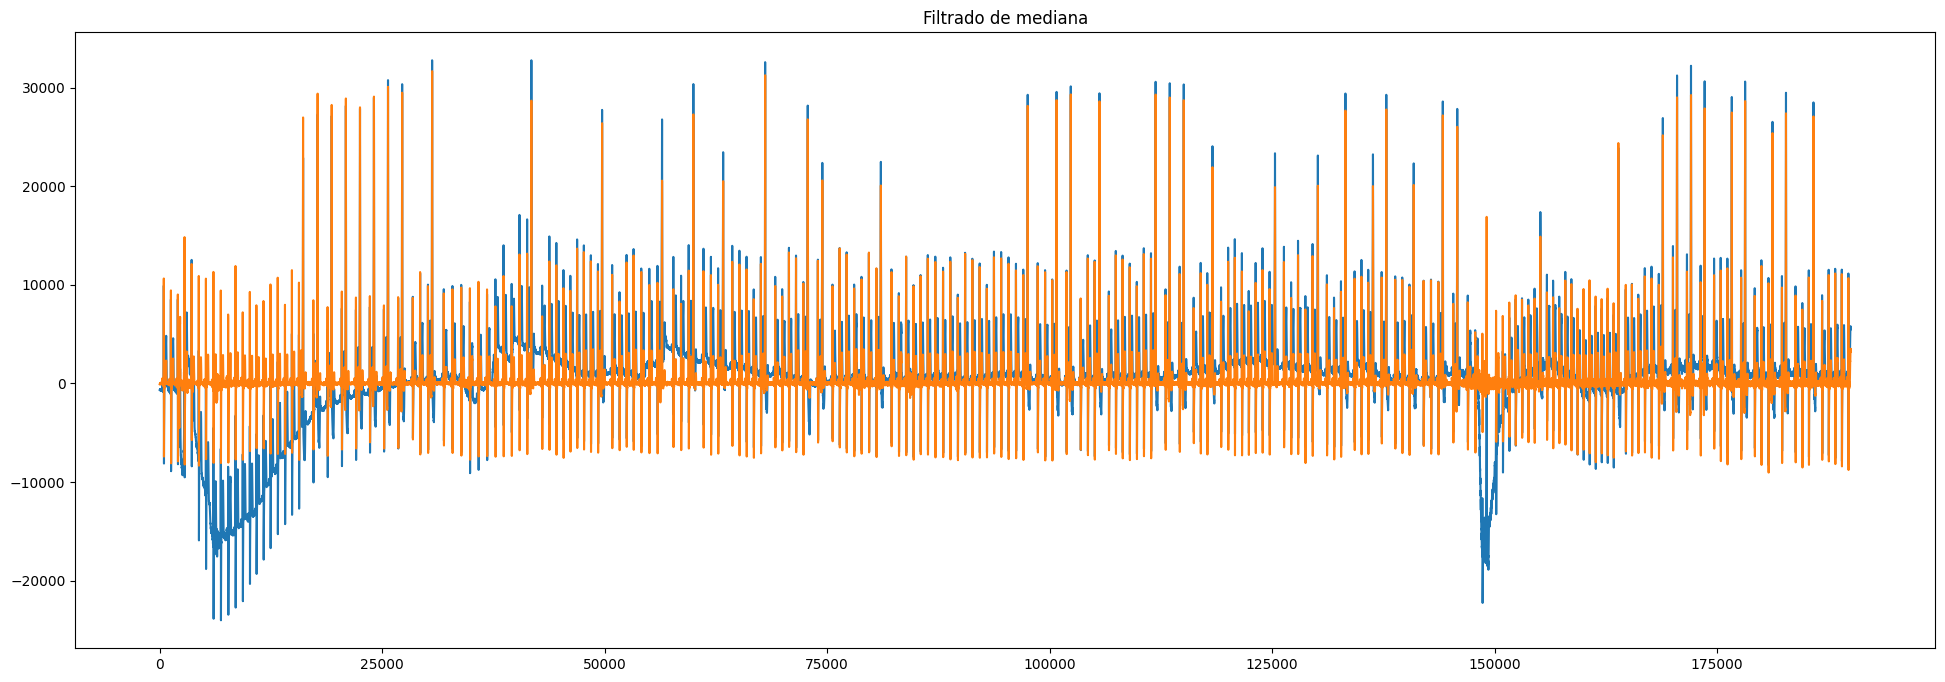

In [2]:
ecg_one_lead_contaminated_filtered_median_big = (
    ecg_one_lead_contaminated_big - sig.medfilt(ecg_one_lead_contaminated_big, 201)
)
plt.figure(figsize=(24, 8))
plt.plot(ecg_one_lead_contaminated_big)
plt.plot(ecg_one_lead_contaminated_filtered_median_big)
plt.title("Filtrado de mediana")
plt.show()

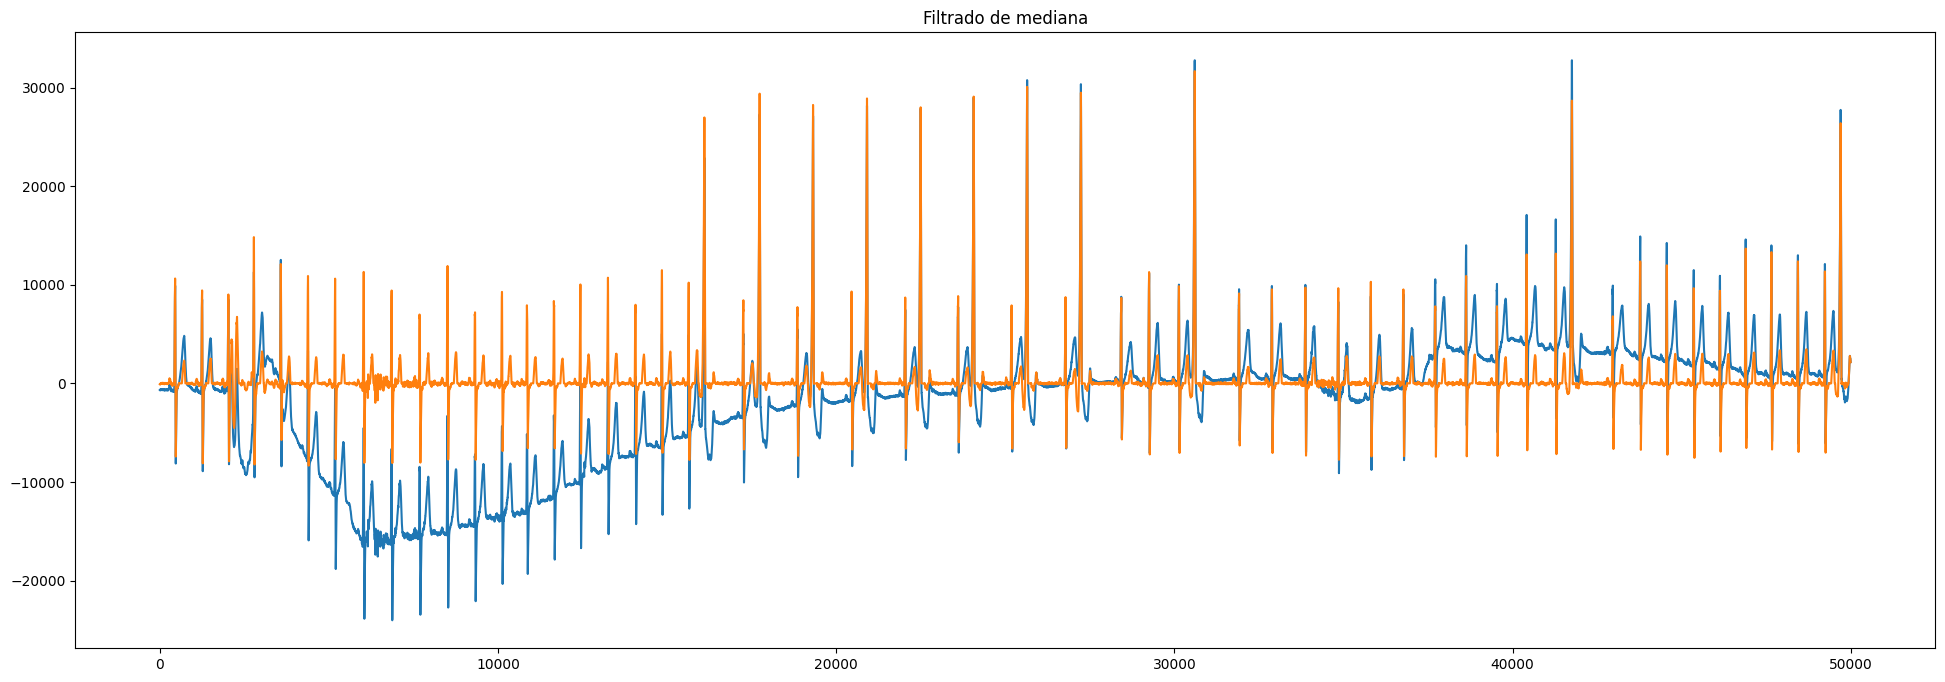

In [3]:
ecg_one_lead_contaminated_filtered_median_small = (
    ecg_one_lead_contaminated_small - sig.medfilt(ecg_one_lead_contaminated_small, 201)
)
plt.figure(figsize=(24, 8))
plt.plot(ecg_one_lead_contaminated_small)
plt.plot(ecg_one_lead_contaminated_filtered_median_small)
plt.title("Filtrado de mediana")
plt.show()

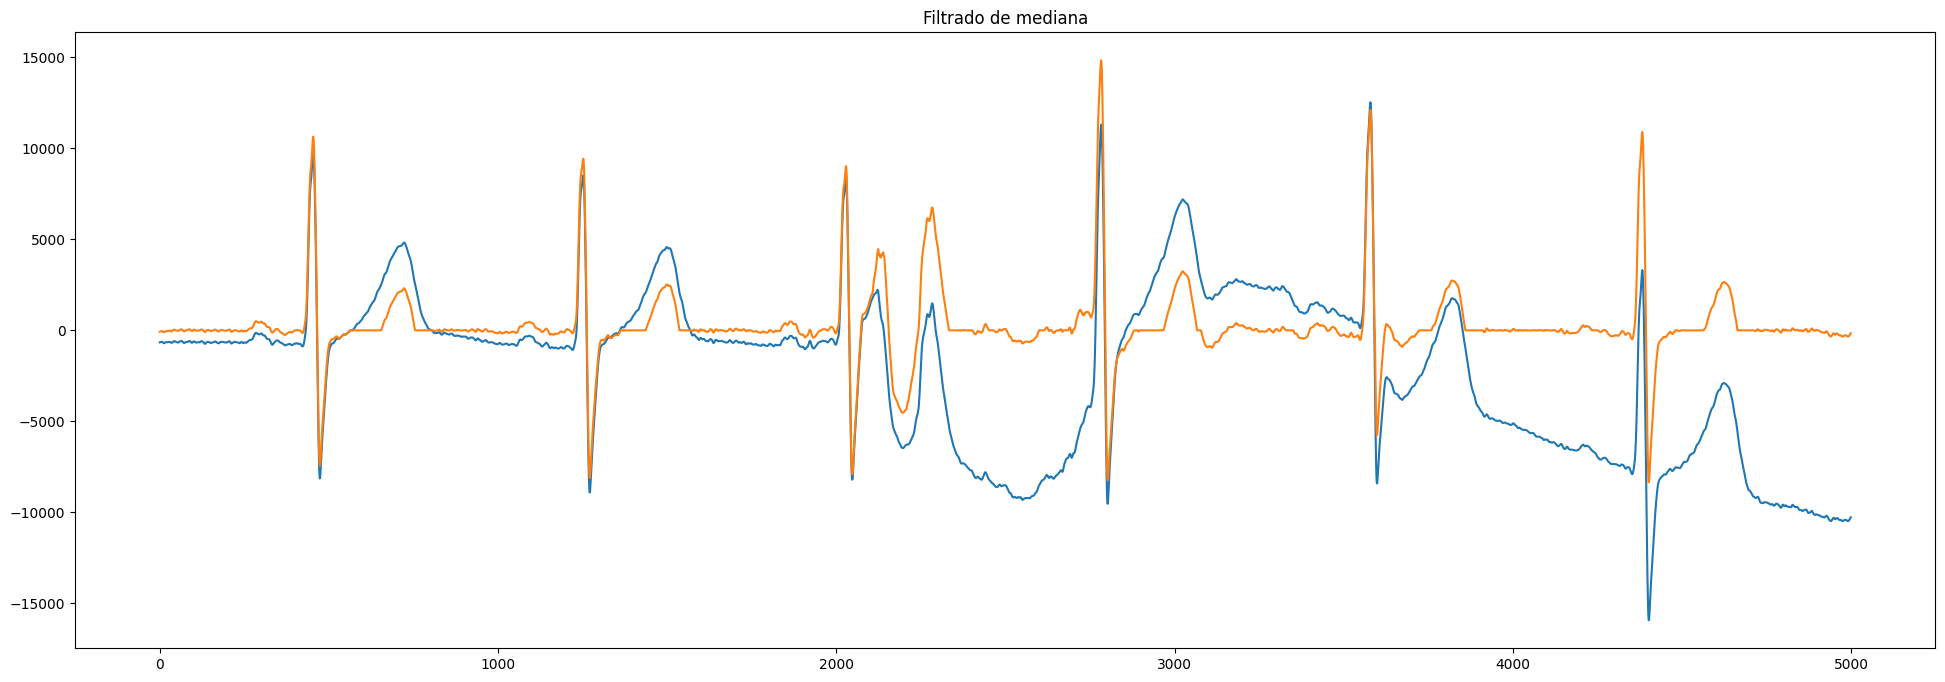

In [4]:
ecg_one_lead_contaminated_filtered_median_smallest = (
    ecg_one_lead_contaminated_smallest
    - sig.medfilt(ecg_one_lead_contaminated_smallest, 201)
)
plt.figure(figsize=(24, 8))
plt.plot(ecg_one_lead_contaminated_smallest)
plt.plot(ecg_one_lead_contaminated_filtered_median_smallest)
plt.title("Filtrado de mediana")
plt.show()

# Filtrado con interpolación conociendo la naturaleza de la señal
En esta sección, se abordará el proceso de filtrado no lineal de la señal de electrocardiograma (ECG) utilizando interpolación spline.

El objetivo principal es estimar el movimiento de línea de base a partir de los segmentos isoeléctricos de cada latido detectado. Para ello, se emplearán las detecciones de picos QRS como referencia para identificar puntos en el tiempo que se encuentran antes del inicio del latido, específicamente 50 ms antes, con el fin de evitar incluir las ondas P y Q en la estimación. La técnica de interpolación spline permite modelar suavemente los segmentos isoeléctricos, proporcionando una representación precisa del nivel isoeléctrico del ECG. 

Este enfoque es fundamental para eliminar las interferencias y resaltar la actividad eléctrica cardíaca real. A lo largo de esta sección, se detallarán los pasos necesarios para implementar este método, incluyendo la recolección de datos, la aplicación del spline cúbico y la visualización de los resultados filtrados.

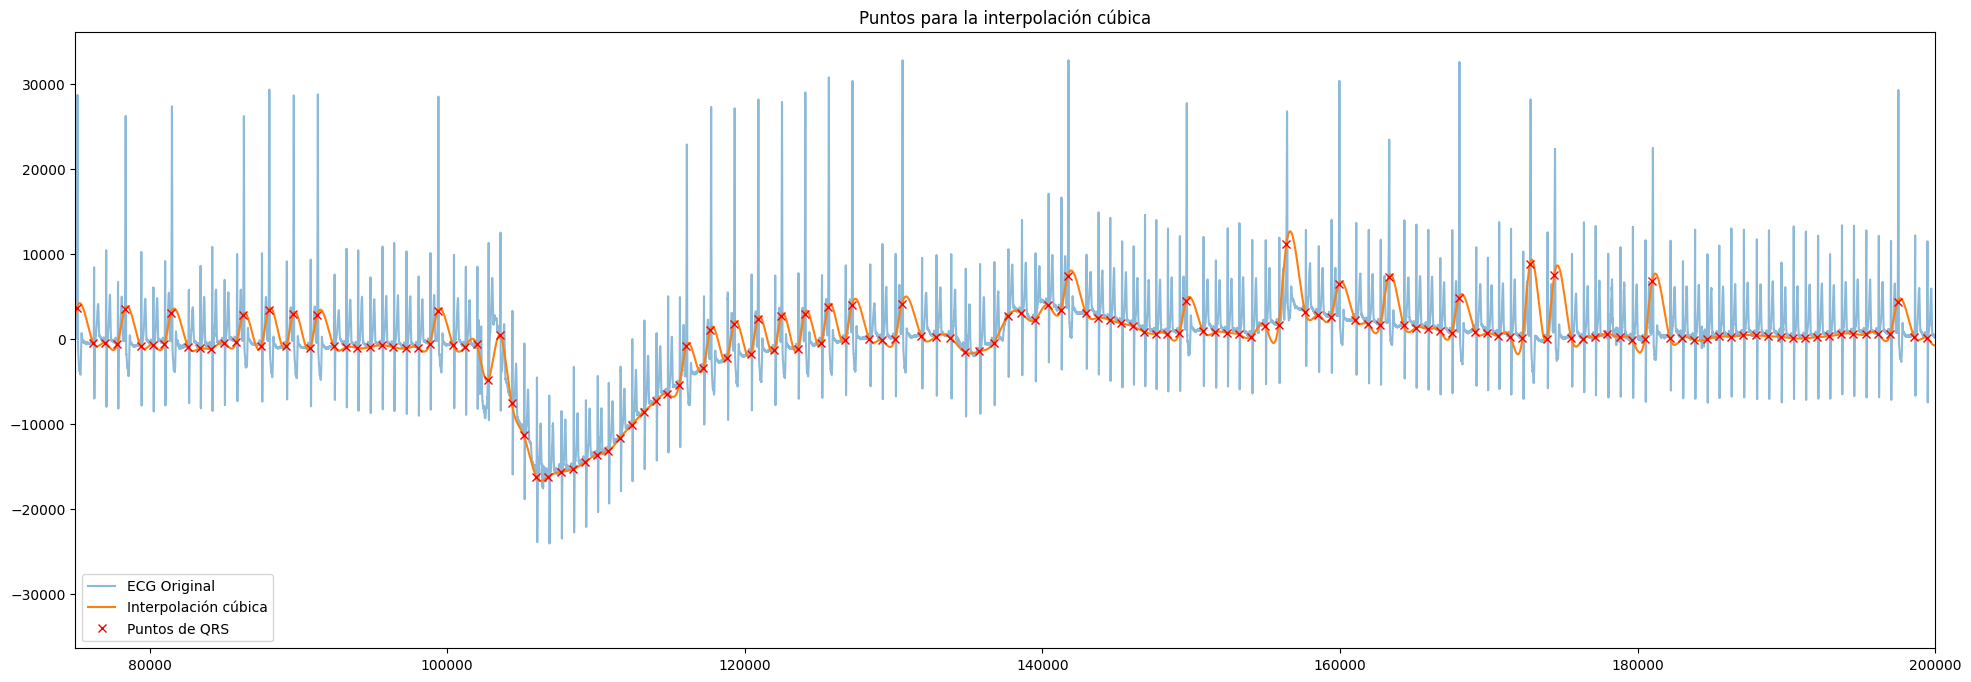

In [5]:
# Vector de localización de los picos donde ocurren los latidos
qrs_d = mat_struct["qrs_detections"].flatten()


def calculate_filtered_with_spline(ecg_data, qrs_d):
    x_points = []
    y_points = []

    for r in qrs_d:
        if r < 50:
            continue
        # 50 muestras antes, equivale a 50 ms
        t = int(r - 50)
        x_points.append(t)
        y_points.append(ecg_data[t])

    # Asegurar que x_points y y_points estén ordenados
    x_points, y_points = zip(*sorted(zip(x_points, y_points)))

    spline = CubicSpline(x_points, y_points)
    filtered = ecg_data - spline(np.arange(len(ecg_data)))

    return filtered, (x_points, y_points), spline


# Filtrar la señal ECG
ecg_one_lead_contaminated_filtered, points, spline = calculate_filtered_with_spline(
    ecg_one_lead, qrs_d
)

# Visualizar la spline y los puntos de QRS - 50ms
plt.figure(figsize=(24, 8))
plt.plot(ecg_one_lead, label="ECG Original", alpha=0.5)
plt.plot(spline(np.arange(len(ecg_one_lead))), label="Interpolación cúbica")
plt.plot(points[0], points[1], "rx", label="Puntos de QRS")
plt.xlim([75000, 0.2e6])
plt.title("Puntos para la interpolación cúbica")
plt.legend()
plt.show()

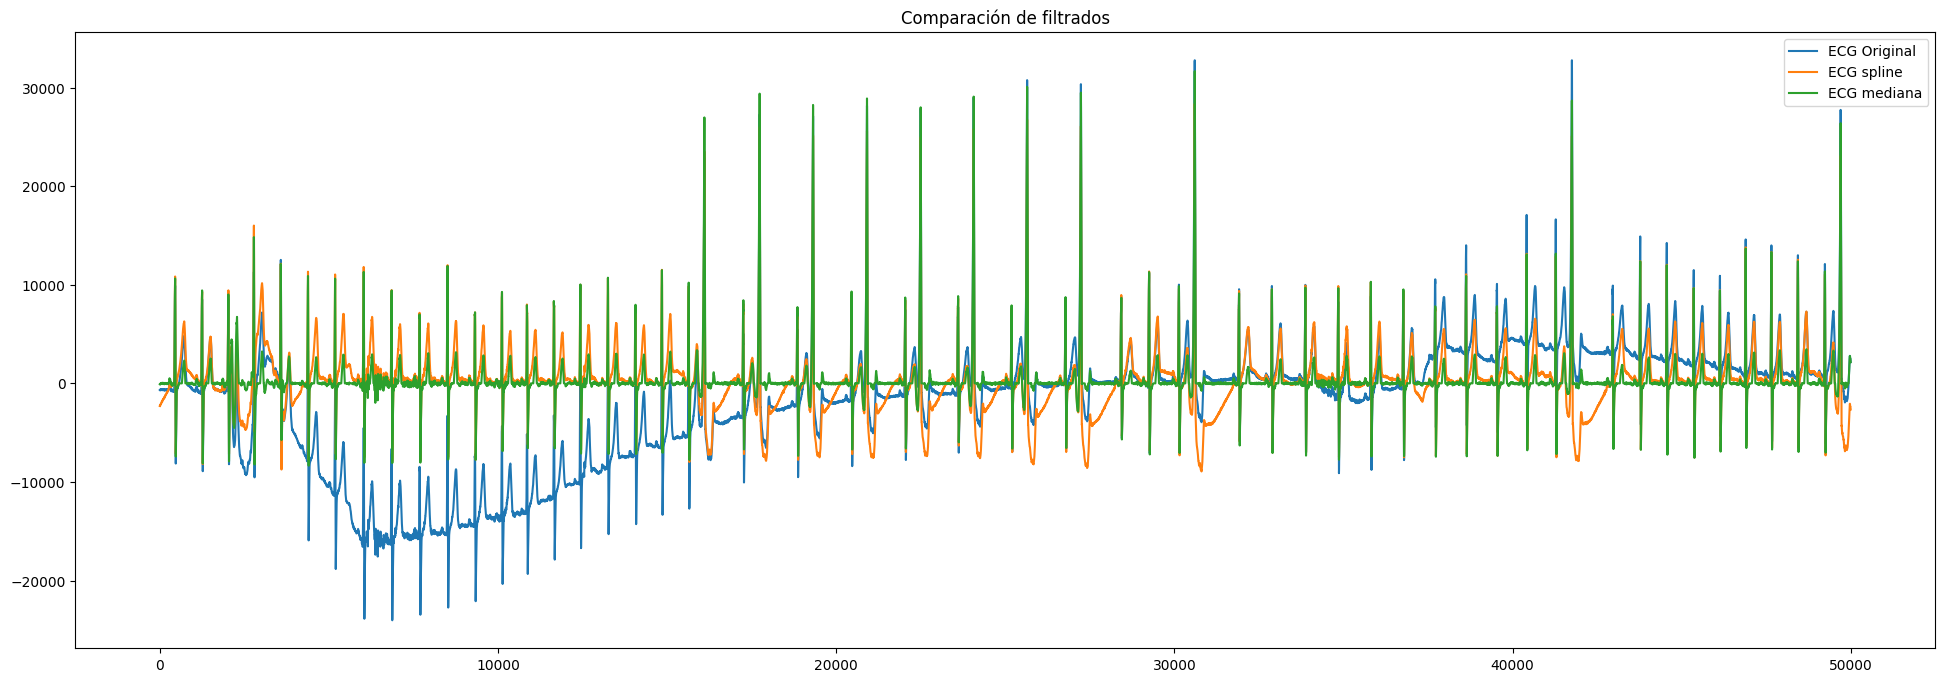

In [6]:
# Visualizar los resultados
plt.figure(figsize=(24, 8))
plt.plot(ecg_one_lead[100000:150000], label="ECG Original")
plt.plot(ecg_one_lead_contaminated_filtered[100000:150000], label="ECG spline")
plt.plot(ecg_one_lead_contaminated_filtered_median_small, label="ECG mediana")
plt.title("Comparación de filtrados")
plt.legend()
plt.show()

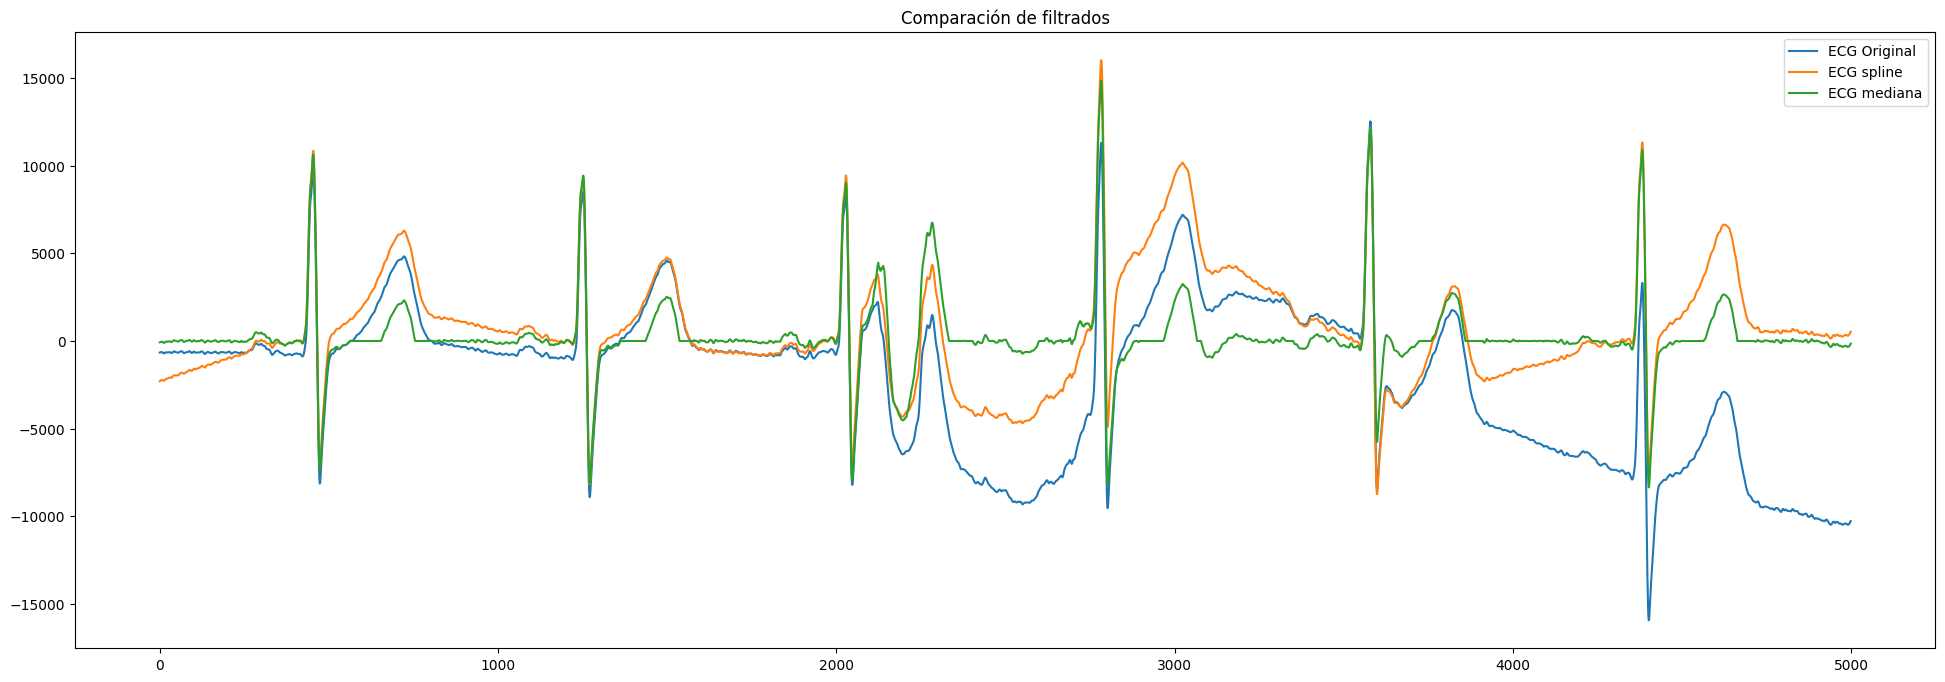

In [ ]:
# Visualizar los resultados
plt.figure(figsize=(24, 8))
plt.plot(ecg_one_lead[100000:105000], label="ECG Original")
plt.plot(ecg_one_lead_contaminated_filtered[100000:105000], label="ECG spline")
plt.plot(ecg_one_lead_contaminated_filtered_median_smallest, label="ECG mediana")

plt.title("Comparación de filtrados")
plt.legend()
plt.show()

# Conclusiones

La estimación del movimiento de línea de base mediante el filtrado de mediana ha demostrado ser efectiva para eliminar interferencias en la señal de electrocardiograma (ECG). Sin embargo, se ha observado que este método puede llevar a una pérdida de resolución, resultando en una señal filtrada que a veces aparece excesivamente lisa o plana. Esto se traduce en un filtrado muy abrupto, donde detalles importantes de la actividad eléctrica cardíaca pueden quedar ocultos.

Por otro lado, al aplicar interpolación spline, se ha notado que este método puede introducir elementos que no son parte de la señal original. Un ejemplo claro se observa en la muestra 3000, donde la spline parece captar variaciones que no corresponden a la actividad cardíaca real. Además, los saltos en la señal después del patrón QRS indican que el spline puede estar generando artefactos no deseados.

En resumen, aunque tanto el filtrado de mediana como la interpolación spline ofrecen ventajas en el procesamiento del ECG, es fundamental considerar sus limitaciones. La mediana puede suavizar demasiado la señal, mientras que la spline puede introducir componentes ajenos a la actividad cardíaca. Por lo tanto, se requiere un enfoque cuidadoso para optimizar estos métodos y preservar las características relevantes del ECG.